In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('../dataset/transform/data.csv')
data = data.fillna(0)
data.head()

,modulation,timeDomain_1,timeDomain_2,timeDomain_3,timeDomain_4,timeDomain_5,timeDomain_6,timeDomain_7,timeDomain_8,timeDomain_9,...,cs_prior__1021,cs_prior__1022,cs_prior__1023,cs_prior__1024,sDomain_max,sDomain_min,sDomain_mean,sDomain_1st_Qu,sDomain_2nd_Qu,sDomain_3rd_Qu
0,8PSK,0.639289,-0.213478,-0.865621,0.386868,0.621987,-0.567360,0.010030,0.373295,-0.150273,...,-0.939505,-0.937342,-1.158446,-1.151277,38.690961,0.037595,5.076279,0.955909,1.621237,7.163684
1,16QAM,-0.343101,-0.515628,-0.672854,0.547040,1.419239,-0.167272,-1.138051,-0.069713,1.464533,...,-1.620745,-1.181503,-1.134026,-0.515628,47.539106,0.000846,5.453533,1.893632,3.143240,5.845227
2,64QAM,-1.054600,-0.523152,0.886420,0.546905,-0.485738,-0.524877,-0.020109,0.228228,0.193880,...,-0.590973,-1.065564,-1.218445,-0.738838,38.200695,0.000383,4.535727,0.325565,0.591289,6.332244
3,BPSK,0.201801,0.990348,-0.083518,-0.947808,0.114776,0.990819,-0.046717,-1.288954,0.392954,...,-0.754663,-0.737908,-0.806254,-0.696160,37.163558,0.006632,4.472471,0.413386,0.768464,5.450173
4,CPFSK,0.168200,0.239790,-0.023122,-0.187393,-0.080768,0.208151,0.165164,-0.273555,-0.237533,...,-1.300745,-1.395009,-1.410663,-1.383565,59.125770,0.056253,4.774119,0.993590,1.838552,4.677182


In [3]:
y = data.modulation
X = data.drop(columns = "modulation").to_numpy()

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

algorithms = {
    "RF" : (RandomForestClassifier(), { "criterion": ["entropy"], "max_depth": [5], "n_estimators": [100] }),
    "DT": (DecisionTreeClassifier(), { "criterion": ["entropy"], "max_depth": [5] })    
}

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, classification_report, jaccard_score, balanced_accuracy_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)
#kf = KFold(n_splits=10, shuffle=True, random_state=17)
gskf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17) 
#gskf = KFold(n_splits=10, shuffle=True, random_state=17)
perf = accuracy_score

correct = {}
for algorithm in algorithms.keys():
    correct[algorithm] = y.copy()

cm = {}
score = {}
predicties = {}
jaccard_scores = {}
classification_reports = {}
balanced_accuracy_scores = { }
for algorithm in algorithms.keys():
    score[algorithm] = []
    predicties[algorithm] = []
    jaccard_scores[algorithm] = []
    cm[algorithm] = np.zeros([8, 8])
    classification_reports[algorithm] = []
    balanced_accuracy_scores[algorithm] = []
        

idx = ["8PSK", "16QAM", "64QAM", "BPSK", "CPFSK", "GFSK", "QPSK", "PAM4"]

for algorithm, (clf, parameters) in algorithms.items():
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        prep.fit(X[train])
        
        best = GridSearchCV(clf, parameters, cv=gskf, scoring="accuracy", return_train_score=True)
        best.fit(prep.transform(X[train]), y[train])
        
        predicted = best.predict(prep.transform(X[test]))
        predicties[algorithm].append(predicted)
        
        cm[algorithm] = np.array(cm[algorithm]) + np.array(confusion_matrix(y[test], predicted, labels=idx))
        jaccard_scores[algorithm].append(jaccard_score(y[test], predicted, average=None))
        classification_reports[algorithm].append(classification_report(y[test], predicted, labels=idx))
        balanced_accuracy_scores[algorithm].append(balanced_accuracy_score(y[test], predicted))
                
        correct[algorithm].loc[test] = predicted == y[test]
        score[algorithm].append(perf(best.predict(X[test]), y[test]))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

In [6]:
print("Mean\n", pd.DataFrame.from_dict(score).mean())
print("\nStd\n", pd.DataFrame.from_dict(score).std())

Mean
 RF    0.139375
DT    0.147250
dtype: float64

Std
 RF    0.008503
DT    0.008245
dtype: float64


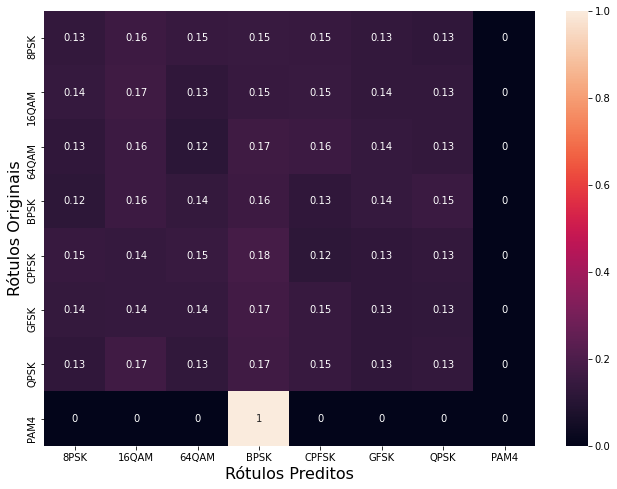

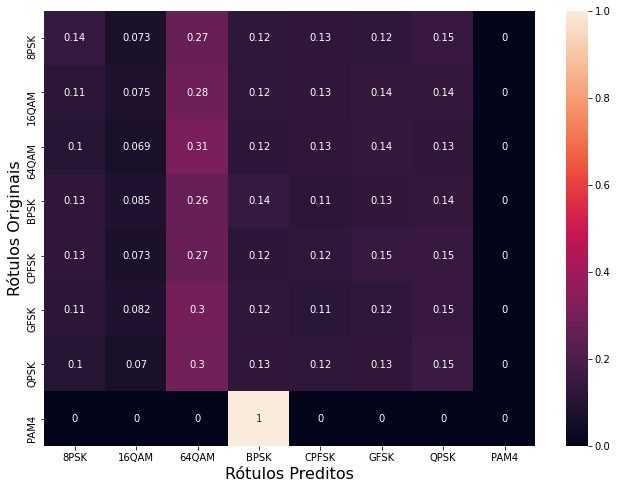

In [7]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

for algorithm in algorithms.keys():
    cm_ = cm[algorithm].astype('float') / cm[algorithm].sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm_, index = [i for i in idx],
                                        columns = [i for i in idx])
    plt.figure(figsize = (11,8))
    sn.heatmap(df_cm, annot=True)
    plt.xlabel('Rótulos Preditos', fontsize=16)
    plt.ylabel('Rótulos Originais', fontsize=16)

In [8]:
import numpy as np
from mlxtend.evaluate import mcnemar_table


In [9]:
# The correct target (class) labels
idx_modulation = {"8PSK":0, "16QAM":1, "64QAM":2, "BPSK":3, "CPFSK":4, "GFSK":5, "QPSK":6, "PAM4":7}
y_target = y.replace(idx_modulation)

# Class labels predicted by model RandomForestClassifier
y_RF = pd.DataFrame.from_dict(correct).RF

# Class labels predicted by model DecisionTreeClassifier
y_DT = pd.DataFrame.from_dict(correct).DT

tb = mcnemar_table(y_target=y_target, 
                   y_model1=y_RF, 
                   y_model2=y_DT)

ct=pd.DataFrame(tb, columns=["RF positive", "RF negative"])
ct.index=["DT positive", "DT negative"] 
ct

,RF positive,RF negative
DT positive,858,209
DT negative,321,6612


In [10]:
from io import StringIO 

clf_df_report = pd.DataFrame.from_dict(classification_reports)
for algorithm in algorithms.keys():
    for cfl_algo_report in clf_report[algorithm]:
        StringData = StringIO(cfl_algo_report)
        df = pd.read_csv(StringData, sep =" ") 
        print(df.precision)
    

,RF positive,RF negative
DT positive,862,205
DT negative,310,6623
